In [1]:
!pip install gensim
!pip install pyLDAvis
!pip install wordcloud
!pip install jsonlines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 41.7 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.5/380.5 KB 69.1 MB/s eta 0:00:00
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=dd2c0b8b7f17240143edf555b0ea3ae83782e23a05a03e5f7dbfec5c13bc4eee
  Stored in directory: /root/.cache/pip/wheels/57/a4/86/d10c6c2e0bf149fbc0afb0aa5a6528ac35b30a133a0270c477
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=3eb0affedac8c45db0cee198c55e7a134fb2dbb86168646c3686a3905bf39ffc
  Stored in directory

In [2]:
#spacy
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

#gensim
import gensim
from gensim import corpora

#Visualization
from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt

#Data loading/ Data manipulation
import pandas as pd
import numpy as np
import jsonlines

#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

#warning
import warnings 
warnings.filterwarnings('ignore')

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-08-26 04:53:35.030120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 04:53:35.030175: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-26 04:53:37.617382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-26 04:53:37.617419: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-

In [3]:
df = pd.read_csv("/work/ResumeLast/Resume/Resume.csv")
df = df.reindex(np.random.permutation(df.index))
data = df.copy().iloc[
    0:200,
]
data.head()

,ID,Resume_str,Resume_html,Category
2371,21287405,P AVIATION SUPPLY SPECIALIST ...,"<div class=""RNA skn-rbn1 fontsize fontface vma...",AVIATION
248,19201175,INFORMATION TECHNOLOGY SPECIALIST ...,"<div class=""skn-cbg1 fontsize fontface vmargin...",INFORMATION-TECHNOLOGY
1061,10138632,SALES MANAGER Professional Summ...,"<div class=""fontsize fontface vmargins hmargin...",SALES
2215,36905896,MEMBER SERVICES REPRESENTATIVE ...,"<div class=""fontsize fontface vmargins hmargin...",BANKING
294,22776912,DIRECTOR OF INFORMATION TECHNOLOGY /C...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY


In [4]:
!pip install -U spacy
!python -m spacy download en_core_web_lg

nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "/work/ResumeLast/jz_skill_patterns.jsonl"

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
2022-08-26 04:54:05.810226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 04:54:05.810261: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-26 04:54:10.420019: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-26 04:54:10.420056: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-26 04:54:10.420082: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-e1a5e65e-1e15-4191-9

In [5]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [6]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset

def unique_skills(x):
    return list(set(x))

In [7]:
import nltk
nltk.download('omw-1.4')
clean = []
for i in range(data.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [8]:
data["Clean_Resume"] = clean
data["skills"] = data["Clean_Resume"].str.lower().apply(get_skills)
data["skills"] = data["skills"].apply(unique_skills)
data.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume,skills
2371,21287405,P AVIATION SUPPLY SPECIALIST ...,"<div class=""RNA skn-rbn1 fontsize fontface vma...",AVIATION,p aviation supply specialist summary ambitious...,"[material, data management, marketing, compute..."
248,19201175,INFORMATION TECHNOLOGY SPECIALIST ...,"<div class=""skn-cbg1 fontsize fontface vmargin...",INFORMATION-TECHNOLOGY,information technology specialist summary rece...,"[design, software, knowledge base, chef, opera..."
1061,10138632,SALES MANAGER Professional Summ...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale manager professional summary accomplished...,"[advertising, design, accounting, specificatio..."
2215,36905896,MEMBER SERVICES REPRESENTATIVE ...,"<div class=""fontsize fontface vmargins hmargin...",BANKING,member service representative summary skilled ...,"[box, security, pose, business]"
294,22776912,DIRECTOR OF INFORMATION TECHNOLOGY /C...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,director information technology chief technolo...,"[mobile, monitoring, business, data sharing, d..."


In [9]:
fig = px.histogram(
    data, x="Category", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()

In [10]:
Job_Category = 'INFORMATION-TECHNOLOGY'

In [11]:
Job_cat = data["Category"].unique()
Job_cat = np.append(Job_cat, "ALL")

In [12]:
Total_skills = []
if Job_Category != "ALL":
    fltr = data[data["Category"] == Job_Category]["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)
else:
    fltr = data["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)

fig = px.histogram(
    x=Total_skills,
    labels={"x": "Skills"},
    title=f"{Job_Category} Distribution of Skills",
).update_xaxes(categoryorder="total descending")
fig.show()

Text(0.5, 1.0, 'Most Used Words in INFORMATION-TECHNOLOGY Resume')

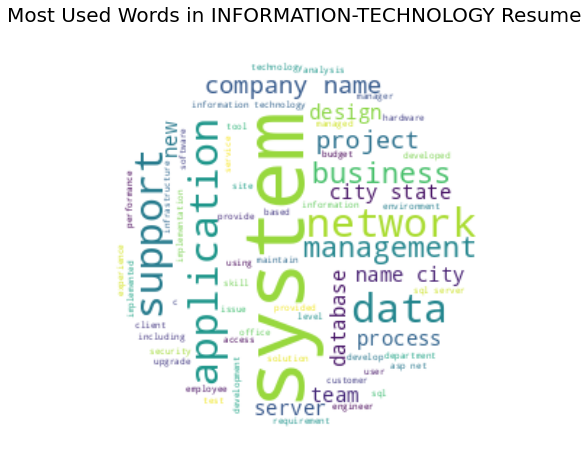

In [13]:
text = ""
for i in data[data["Category"] == Job_Category]["Clean_Resume"].values:
    text += i + " "

plt.figure(figsize=(8, 8))

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in {Job_Category} Resume", fontsize=20)

In [14]:
sent = nlp(data["Resume_str"].iloc[0])
displacy.render(sent, style="ent", jupyter=True)

In [15]:
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance": 90})

In [16]:
patterns = df.Category.unique()
for a in patterns:
    ruler.add_patterns([{"label": "Job-Category", "pattern": a}])

In [17]:
# options=[{"ents": "Job-Category", "colors": "#ff3232"},{"ents": "SKILL", "colors": "#56c426"}]
colors = {
    "Job-Category": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
sent = nlp(data["Resume_str"].iloc[5])
displacy.render(sent, style="ent", jupyter=True, options=options)

In [18]:
input_resume = 'Navamshu Ram PV 28/02/2002 7483044907 navamshuram navamshuram navamshuram2002@gmail.com Profile Solid ability to translate business requirements into technical solutions. Looking to start the career as an entry-level developer with firm driven by technology. Education Sathyabama Institute of Science and Technology Computer Science and Eng ineering | 2019-2023 CGPA : 8.7 Excellent PU College Department of Pre-University Education | 2017-2019 Percentage : 86% Amrita Vidyalayam Central Board of Secondary Education | 2017 CGPA : 10 Technical Skills SaaS Development Rest Api Golang Web Scraping Selenium Python MySQL Html-Css & Javascript Professional Experience Software Development Intern, Cubestech Ltd A backend developer role in creating a SaaS product using Go programming language and Rest Api. Intially, I went through Selenium tool to work on web scraping in Python. Completed tasks in real time, such as captcha solver using Tensor Flow, Zinnext website extraction. Course & Certificates Bootstrap 4 Front-End Web Development with React NodeJS, Express and MongoDB Full-Stack Web Development with React (Honors) Bootcamp on Netflix clone Machine LearningProjects Attendance Management System, OpenCV Created a advance face recognition student attendance system project using Python, OpenCV, Tkinter Gui and MySQL database. Haarcascade for object detection and LBPH for face recognition algorithms have been used. Text via Captcha Image, Tensor Flow Captcha is a challenge-response test used in  computing to determine whether or not the user is  human. We can train a Deep learning model to predict  the text in a captcha image. The Dataset are hand picked from certain websites  using web scrapping method of about 10,000 captcha  images. Split the captcha image into separate letters. Used the  trained model to predict the letters separately. After  the predictions of all six letters, combined the  predictions to form the captcha output. Cuisine-Application, Flexbox & JavaScript This is a fully responsive restaurant website, maximum compatibilities in all mobile devices, built using HTML, CSS and JavaScript. Motivating Force, Flexbox & Javascript Advisor is a simple, minimalist web app ,which uses API to give users random piece of advice/life-hacks, every time the user visits and also when clicking a button. To Do List, Flexbox & Javascript User can write to-do items in an input, and can add the items to an array by clicking the “+” icon. User can also mark the task as completed and then filter the to- do based on completed, uncompleted or all to-do. Covid Prediction, Random Forest Partaken in Virtual Hackathon challenge and completed a mini project on Covid-Prediction for next 30 days using LSTM and Random Forest. In-Vehicle Coupon Recommendation, Decision Tree Completed a mini project with Decision Tree algorithm to recommend coupons for driver.'

In [19]:
sent2 = nlp(input_resume)
displacy.render(sent2, style="ent", jupyter=True, options=options)

In [21]:
input_skills = 'Python,JavaScript'

In [22]:
req_skills = input_skills.lower().split(",")
resume_skills = unique_skills(get_skills(input_resume.lower()))
score = 0
for x in req_skills:
    if x in resume_skills:
        score += 1
req_skills_len = len(req_skills)
match = round(score / req_skills_len * 100, 1)

print(f"The current Resume is {match}% matched to your requirements")

The current Resume is 100.0% matched to your requirements


In [23]:
print(resume_skills)

['opencv', 'mobile', 'business', 'programming language', 'decision tree', 'database', 'algorithms', 'algorithm', 'random forest', 'python', 'software', 'rest api', 'javascript', 'bootstrap', 'selenium', 'mongodb', 'mysql', 'web app', 'object detection', 'react', 'deep learning']


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e1a5e65e-1e15-4191-9d01-916565a7c752' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>